In [1]:
import os
import gc
import sys
import warnings
from pathlib import Path

import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Load datasets

In [4]:
df_names = ['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events',
           'games', 'standings', 'rosters', 'transactions']
path = "data/train_vs/"

train_dict = {}
for index in range(len(df_names)):
    train_dict[df_names[index]] = pd.read_pickle(os.path.join(path,df_names[index]) + "_train.pkl")

In [5]:
df_names = ['seasons', 'teams', 'players', 'awards']
path = "data/"

my_dict = {}
for index in range(len(df_names)):
    my_dict[df_names[index]] = pd.read_csv(os.path.join(path,df_names[index]) + ".csv")

In [6]:
target = pd.read_pickle('data/target_v/nextDayPlayerEngagement_train.pkl')
target = target.drop(['index', 'date'], axis = 1)
target.head()

,engagementMetricsDate,playerId,target1,target2,target3,target4
0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294
1,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118
2,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667
3,2018-01-02,607625,0.006700,2.675097,0.005168,1.862745
4,2018-01-02,592547,0.001117,0.632296,0.002953,0.931373


## Target Variable Analysis

1. How many players are here?

In [7]:
player_519317 = target[target['playerId'] == 519317]
player_519317 = player_519317.drop(['playerId'], axis = 1).set_index('engagementMetricsDate')

<AxesSubplot:xlabel='engagementMetricsDate'>

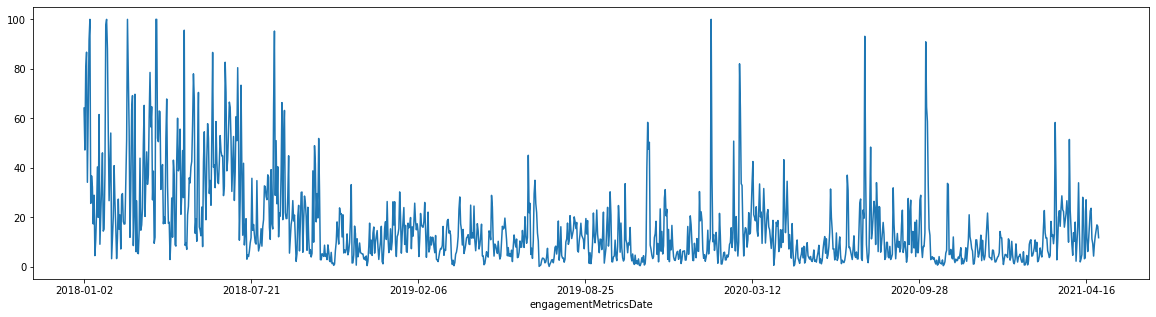

In [8]:
player_519317['target4'].plot(figsize=(20,5))

In [9]:
player_num = len(target['playerId'].unique())
print("There are {} players in this dataset".format(player_num))

There are 2061 players in this dataset


The date ranges from 2018-01-02 to 2021-05-01, 3 years and 4 months in total.

In [10]:
target_date = target.groupby('engagementMetricsDate').mean().drop(['playerId'], axis = 1)
target_date.head(3)

,target1,target2,target3,target4
engagementMetricsDate,,,,
2018-01-02,0.213906,2.889072,1.096593,1.498630
2018-01-03,0.134676,1.656669,0.586616,1.014239
2018-01-04,0.138039,1.703637,0.640385,1.627010


In [11]:
target_player = target.groupby('playerId').mean()
target_player.head(3)

,target1,target2,target3,target4
playerId,,,,
112526,0.955238,4.958954,2.211032,15.248990
134181,1.805470,3.599672,2.650725,7.012093
279571,0.010480,0.361597,0.048923,0.302383


In [12]:
quant_09 = target_player.quantile(.9)

In [13]:
quant_01 = target_player.quantile(.1)

In [14]:
players_09 = target_player.loc[(target_player['target1'] > quant_09['target1']) & (
    target_player['target2'] > quant_09['target2']) & (target_player['target3'] > quant_09['target3']) & (
    target_player['target4'] > quant_09['target4'])]

In [15]:
players_01 = target_player.loc[(target_player['target1'] < quant_01['target1']) & (
    target_player['target2'] < quant_01['target2']) & (target_player['target3'] < quant_01['target3']) & (
    target_player['target4'] < quant_01['target4'])]

In [16]:
players_09.shape

(115, 4)

In [17]:
players_01.shape

(50, 4)

There are 115 players whose 4 targets values are above the 0.9 quantile, while there are 50 players whose target values fall below the 0.1 quantile.

In [18]:
target_player.cov()

,target1,target2,target3,target4
target1,1.628622,3.454547,1.682768,2.265544
target2,3.454547,9.056181,3.850984,5.561003
target3,1.682768,3.850984,2.006660,2.645289
target4,2.265544,5.561003,2.645289,5.208776


In [19]:
log_player = np.log(target_player+1)
log_date = np.log(target_date+1)

In [20]:
# sns.set(style="darkgrid")
# ax = sns.displot(log_date, kind="kde", legend=True)
# ax.set(xlabel='target values')

In [21]:
# ax = sns.displot(log_player, kind="kde", legend=True)
# ax.set(xlabel='target values')

In [22]:
target_player.head(3)

,target1,target2,target3,target4
playerId,,,,
112526,0.955238,4.958954,2.211032,15.248990
134181,1.805470,3.599672,2.650725,7.012093
279571,0.010480,0.361597,0.048923,0.302383


In [23]:
target_date['target1'].max()

1.8817910539582565

A lot of "outliers" on the top, but not the bottom.

<AxesSubplot:>

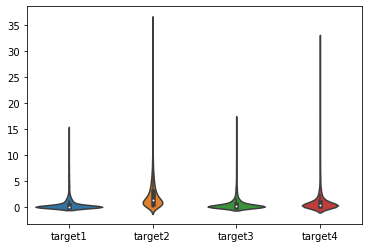

In [24]:
sns.violinplot(data = target_player)

In [25]:
### do not need this one because the time series plot will show the property better
# sns.boxplot(data = target_date)

<AxesSubplot:xlabel='engagementMetricsDate'>

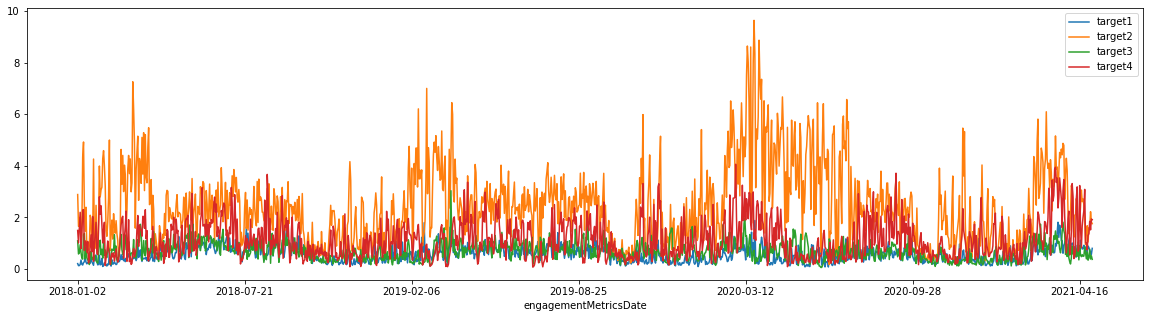

In [26]:
target_date.plot(figsize=(20,5))

In [ ]:
# fig, axs = plt.subplots(4, figsize=(20, 12), sharex=True)

# for i,j in enumerate(target_date.columns[:4]):
#     axs[i].plot(target_date[j])
#     axs[i].set_xticks(target_date.index[::120])
#     axs[i].title.set_text(j)

# plt.show()

From the ACF, we can see that there are about 60-day significant lags and a one-year correlation.

In [ ]:
fig, axs = plt.subplots(4, figsize=(20, 12), sharex=True)

for i,j in enumerate(target_date.columns):
    pd.plotting.autocorrelation_plot(target_date[j], ax = axs[i])
    axs[i].title.set_text(j)

plt.show()

### Seasonal Plots

In [27]:
series = target_date['target1']
result = seasonal_decompose(series, model='additive', period = 365)

<AxesSubplot:xlabel='engagementMetricsDate'>

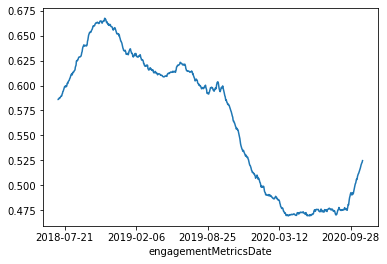

In [28]:
# trend is not a good choice
result.trend.plot()

In [29]:
result.seasonal.loc[(result.seasonal > 1)]

engagementMetricsDate
2018-03-24    1.215342
2019-03-24    1.215342
2020-03-23    1.215342
2021-03-23    1.215342
Name: seasonal, dtype: float64

In [30]:
result.seasonal.loc[(result.seasonal < -0.4)]

engagementMetricsDate
2018-11-03   -0.409936
2018-11-20   -0.406570
2019-11-03   -0.409936
2019-11-20   -0.406570
2020-11-02   -0.409936
2020-11-19   -0.406570
Name: seasonal, dtype: float64

In [ ]:
result.seasonal.plot(figsize = (20,5))

The peaks happen on Mar.23rd and low in Nov, follows the seasons of the events.
Although in 2020, the regular season start late (Covid?), the peak happened regularly, may due to the publicity.

The preseason starts at the end of Feb each year, and end after one month. But in 2020, it ends in July due to covid.

In [ ]:
seasons = my_dict['seasons']
seasons

## Train Dataset Analysis

In [ ]:
train_dict['playerBoxScores'].columns

In [ ]:
performance = train_dict['playerBoxScores'][['gameTimeUTC', 'playerId', 'positionName', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']]

In [ ]:
scores = ['gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

In [ ]:
# performance.set_index("playerId", inplace = True)
perform_data = performance[scores]

In [ ]:
perform_corr = perform_data.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(20,25))
sns.heatmap(perform_corr, annot = False, ax=ax)

In [ ]:
perform_stats = pd.DataFrame()

### Defense

In [ ]:
perform_stats['FPCT'] = (performance['putOuts']+performance['assists']) / performance['chances']

# Not sure
perform_stats['Out'] = performance['putOuts'] + performance['groundOuts'] + performance['strikeOuts'] + performance['flyOuts']

### Offence

In [ ]:
perform_stats['AB'] = performance['atBats']

# Not sure
perform_stats['B2'] = performance['doubles']
perform_stats['B3'] = performance['triples']

perform_stats['SB'] = performance['stolenBases']
perform_stats['CS'] = performance['caughtStealing']
perform_stats['H'] = performance['hits']
perform_stats['HR'] = performance['homeRuns']
perform_stats['IBB'] = performance['intentionalWalks']
perform_stats['HBP'] = performance['hitByPitch']
perform_stats['LOB'] = performance['leftOnBase']
perform_stats['PA'] = performance['plateAppearances']
perform_stats['TB'] = performance['totalBases']
perform_stats['GIDP'] = performance['groundIntoDoublePlay']
perform_stats['RBI'] = performance['rbi']
perform_stats['BB'] = performance['baseOnBalls']
perform_stats['SO'] = performance['strikeOuts']

### Pitching

In [ ]:
perform_stats['SV_percnt'] = performance['saves']/performance['saveOpportunities']

perform_stats['HLD'] = performance['holds']

perform_stats['BS'] = performance['blownSaves']

perform_stats['IR'] = performance['inheritedRunners']

perform_stats['IP'] = performance['inningsPitched']

perform_stats['ERA'] = (9*performance['earnedRuns'])/IP

perform_stats['WHIP'] = (BB + H)/IP

In [ ]:
### Advanced

In [ ]:
perform_stats['ISO'] = (B2+2*B3+3*HR)/AB

perform_stats['RC'] = TB*(H+BB)/(AB+BB)

In [ ]:
# perform_stats['Game_Score'] = 40 + 6*Out + SO - 2*performance['baseOnBallsPitching'] - 2*performance['hitsPitching'] -3*performance['runsPitching'] - 6*performance['homeRunsPitching']

In [ ]:
perform_stats['playerId'] = performance['playerId']
perform_target = perform_stats.merge(target_player, on = ['playerId'], how = 'left')

In [ ]:
target_corr = perform_target.corr()[['target1', 'target2', 'target3', 'target4']]

In [ ]:
target_corr = target_corr.iloc[:-5]

In [ ]:
target_corr['mean_target'] = target_corr.mean(axis = 1)
target_corr = target_corr.sort_values(by = 'mean_target', ascending = False)

In [ ]:
target_corr.plot.bar(figsize = (16,5))

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# sns.heatmap(perform_stats.corr(), annot = True, ax=ax)

In [ ]:
# perform_stats_new = perform_stats.drop(['SV_percnt', 'HLD', 'BS', 'IR', 'IP', 'ERA', 'WHIP'], axis = 1)

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# sns.heatmap(perform_stats_new.corr(), annot = True, ax=ax)

In [ ]:
# perform_stats_new['playerId'] = performance['playerId']

# perform_target = perform_stats_new.merge(target_player, on = ['playerId'], how = 'left')

In [ ]:
# fig, ax = plt.subplots(figsize=(15,15))
# sns.heatmap(perform_target.corr(), annot = True, ax=ax)

### Game_Score
Not correlated with target

In [ ]:
Game_Score = 40 + 6*Out + SO - 2*performance['baseOnBallsPitching'] - 2*performance['hitsPitching'] -3*performance['runsPitching'] - 6*performance['homeRunsPitching']

In [ ]:
sns.distplot(Game_Score)

### Offense

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(train_dict['playerBoxScores'][['jerseyNum','positionCode', 'date']])

In [ ]:
from pyppca import ppca

In [ ]:
performance.head()

Use probabilities PCA
https://github.com/el-hult/pyppca/tree/master/pyppca

In [ ]:
# C, ss, M, X, Ye  = ppca(performance[scores].to_numpy(), d = 10, dia = True)

In [ ]:
train_dict.keys()

In [ ]:
train_dict['playerBoxScores']['playerId']

In [ ]:
# train_dict['playerTwitterFollowers'][train_dict['playerTwitterFollowers']['playerId']==430897]

In [ ]:
pick_playerBox = ['gamePk', 'gameDate', 'teamId', 'playerId', '']

In [ ]:
train_dict['playerBoxScores']

In [ ]:
len(train_dict['events']['gamePk'].unique())

In [ ]:
len(train_dict['games']['gamePk'].unique())

In [ ]:
train_dict['rosters'].head(3)

In [ ]:
train_dict['standings'].head(3)

In [ ]:
There are 392 different awards, 

In [ ]:
len(train_dict['awards']['awardName'].unique())

In [ ]:
len(train_dict['awards']['awardName'].unique())

In [ ]:
te = train_dict['awards'].merge(players[['playerId', 'playerName']], on = ['playerId'], how = 'left')

awards df contains players in 2017 season. We can delete them.

In [ ]:
len(train_dict['awards']['playerName'].unique())

In [ ]:
# target_player

In [ ]:
players = my_dict['players']

In [ ]:
players.head()

In [ ]:
target_position = target_player.merge(players[['playerId', 'primaryPositionName']], on = 'playerId', how = 'left')

In [ ]:
target_position_mean = target_position.groupby('primaryPositionName').mean().drop(['playerId'], axis = 1)

In [ ]:
target_position_mean['mean'] = target_position_mean.mean(axis = 1)
target_position_mean = target_position_mean.sort_values(by = 'mean', ascending = False)

In [ ]:
target_position_mean.plot.bar()

The designated hitter has the highest target value of all (all 4 values), while infield got very few attention.

## Start a RF

In [ ]:
### Construct variables

In [6]:
target_v = pd.read_pickle('data/target_v/nextDayPlayerEngagement_train.pkl')

In [7]:
target_v = target_v.drop(['index'], axis = 1)

In [8]:
target_v.shape

(2506176, 7)

In [ ]:
train_dict['playerBoxScores'].columns

In [9]:
select_pScore_raw = train_dict['playerBoxScores'].drop(
    ['teamName', 'playerName', 'jerseyNum', 'positionName', 'positionType', 'index'], axis = 1)

In [10]:
select_pScore_raw.head(3)

,home,gamePk,gameDate,gameTimeUTC,teamId,playerId,positionCode,battingOrder,gamesPlayedBatting,flyOuts,...,sacBuntsPitching,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,date
0,1,529418,2018-03-29,2018-03-29T23:08:00Z,119,605131,12,601.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20180329
1,1,529406,2018-03-29,2018-03-29T20:00:00Z,139,605480,7,601.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,20180329
2,0,529416,2018-03-29,2018-03-29T20:10:00Z,143,546318,8,401.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,20180329


In [11]:
train_dict.keys()

dict_keys(['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events', 'games', 'standings', 'rosters', 'transactions'])

In [15]:
select_pScore_raw = train_dict['playerBoxScores'][['playerId', 'gamePk']]

In [16]:
target_v1 = target_v.merge(select_pScore_raw, on = ['playerId'], how = 'left')

In [20]:
target_v.head()

,engagementMetricsDate,playerId,target1,target2,target3,target4,date
0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,20180101
1,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118,20180101
2,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667,20180101
3,2018-01-02,607625,0.006700,2.675097,0.005168,1.862745,20180101
4,2018-01-02,592547,0.001117,0.632296,0.002953,0.931373,20180101


In [24]:
target_v = target_v.set_index('playerId')

In [26]:
target_v

,engagementMetricsDate,target1,target2,target3,target4,date
playerId,,,,,,
628317,2018-01-02,0.011167,4.474708,0.005168,5.735294,20180101
547989,2018-01-02,0.042993,5.593385,0.045033,2.794118,20180101
519317,2018-01-02,0.974327,56.177043,13.693746,64.166667,20180101
607625,2018-01-02,0.006700,2.675097,0.005168,1.862745,20180101
592547,2018-01-02,0.001117,0.632296,0.002953,0.931373,20180101
...,...,...,...,...,...,...
451661,2021-05-01,0.000000,0.013314,0.000000,0.625925,20210430
519301,2021-05-01,0.000131,0.003329,0.000000,0.216229,20210430
527055,2021-05-01,0.000000,0.019971,0.000000,0.273131,20210430


In [27]:
target_v.iloc['playerId' == 628317]

TypeError: Cannot index by location index with a non-integer key

In [21]:
select_pScore_raw.head()

,playerId,gamePk
0,605131,529418
1,605480,529406
2,546318,529416
3,527043,529412
4,449181,529408


In [18]:
target_v1.head()

,engagementMetricsDate,playerId,target1,target2,target3,target4,date,gamePk
0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,20180101,529442.0
1,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,20180101,529524.0
2,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,20180101,529597.0
3,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,20180101,529677.0
4,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,20180101,529751.0


In [ ]:
target_v1[['gamePk', 'gameDate', 'gameTimeUTC']].isnull().sum()

In [ ]:
# We do not want to add this because it will cause the multicollinearity problem
train_dict['teamBoxScores'].shape

In [ ]:
select_awards = train_dict['awards'].drop(['awardName', 'playerName', 'index'], axis = 1)
select_awards.head(3)

In [ ]:
target_v2 = target_v1.merge(select_awards, on = ['playerId', 'date'], how = 'left')

In [ ]:
target_v2.shape

In [ ]:
events = train_dict['events']
events.head(3)

In [ ]:
select_events = events[['gamePk', 'gameDate', 'gameTimeUTC', 'gameType', 'eventId', 'inning', 'halfInning', 'homeScore', 'awayScore',
       'menOnBase', 'atBatIndex', 'atBatDesc', 'atBatEvent', 'hasOut',
       'pitcherTeamId', 'isPitcherHome', 'pitcherId', 'hitterId','balls', 'strikes', 'date']]

In [ ]:
select_events[['gamePk', 'gameDate', 'gameTimeUTC','date']]

In [ ]:
target_v2[['gamePk', 'gameDate', 'gameTimeUTC','date']]['gamePk'].isnull().sum()

In [ ]:
target_v3 = target_v2.merge(select_events, on = ['date'], how = 'left')

In [ ]:
target_v3.shape

In [ ]:
target_v3.columns

In [ ]:
train_dict['games'].columns

In [ ]:
selected_games = train_dict['games'][[
    'gamePk', 'gameType', 'gameDate', 'gameTimeUTC','detailedGameState', 'isTie','homeWinPct', 'awayWinPct', 'homeScore','awayScore']]

In [ ]:
target_v4 = target_v3.merge(select_events, on = ['gamePk', 'gameType', 'gameDate', 'gameTimeUTC'], how = 'left')

In [ ]:
target_v3.shape